<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/W266Multi%2BBinary_CK_11_22_BruteForce_nolexical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Set up 

In this notebook 
a ) I am using data from GCS, from courtney which is cleaned for age and other additional columns , 
b) I am also removing AGE from the model and lower string transformations
c) cleaning up the notebook for only model as of now

In [1]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Nov 26 23:10:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    47W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# imports
import sys
import csv

#import unidecode 
#import unicodedata
import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap
import re
import time

In [3]:
!pip install transformers
import os, re
import time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
from io import BytesIO
from transformers import AutoTokenizer, TFAutoModel
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score, precision_score, f1_score,matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 7.2 MB/s 
     |████████████████████████████████| 7.6 MB 55.8 MB/s 
     |████████████████████████████████| 182 kB 80.6 MB/s 


In [4]:
#imports and installs for feature engineering
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 3.5 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57822 sha256=e6de5d92d829a0811fb2e787812ff60cf7d96c7d8a65e5712e682276ebaa1502
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 7.7 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=2c0caf188bb9969aef7b3bedb6cc21d06472fca1e3fe36cf64593b688f46b3a4
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    uploaded = files.upload()



def config_GCloud():
    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

 
    return gcloud_bucket, gcloud_bucket_name


In [6]:
upload_gcloud_credentials()

Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json


In [7]:
bucket, bucket_name = config_GCloud()

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
test_is_I_data.parquet
te

In [8]:
bert_model_name='bert-base-cased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = TFAutoModel.from_pretrained(bert_model_name)
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_model.trainable = False



Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Data Prep Training and Validation

In [9]:
# max_length=500
#increasing max length by 250 to accomodate additional tags and user info
max_length = 750
batch_size = 32

In [10]:
# setup google drive access for checkpoint file

from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/W266/MBTI/model_checkpoints"

Mounted at /content/drive
'Colab Notebooks'   content   MIDS   ULondon   W266
bert_multibinary_1120.hdf5  bert_multibinary_1122_noemote.hdf5


In [11]:
# Checkpoint configurations on google drive 

checkpoint_dir = 'drive/MyDrive/W266/MBTI/model_checkpoints/'
#checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_filepath = checkpoint_dir + 'bert_multibinary_1120.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    #save_freq =100*batch_size
    )

In [12]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [13]:
def combine_no_username(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df

def combine_no_emotion(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+ "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df


def combine_no_lexical(df):
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df

def combine_no_pos(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + df['message'].astype(str)
    return df


def combine_all(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = df['Username'].astype(str)+" [SEP] " + df['Age'].astype(str)+" [SEP] "+df['Posts'].astype(str)+" [SEP] "+df['Occupation'].astype(str)+" [SEP] "+"lexical categories: "+df['lexicon'].astype(str)+ " [SEP] "+"emotion scores: "+df['emotions'].astype(str)+" [SEP] " + "pos tags: "+df['postags'].astype(str)+ " [SEP] " + df['message'].astype(str)
    return df


def add_features(df):
    # first remove Username
    return combine_no_lexical(df)
    

In [14]:
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
#remove gender from the train data set
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]
#train_mbti_data, train_mbti_labels = train_mbti_data[120000:130000], train_mbti_labels[120000:130000]
#train_mbti_data, train_mbti_labels = train_mbti_data[:40000], train_mbti_labels[:40000]
#train_mbti_data = add_features(train_mbti_data)

dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
#dev_mbti_data, dev_mbti_labels = dev_mbti_data[:2000], dev_mbti_labels[:2000]
#remove gender from the dev data set 
dev_mbti_data = dev_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [15]:
train_mbti_data.count()

Username      1200000
Age           1200000
Posts         1200000
Occupation     623662
message       1200000
is_I          1200000
is_S          1200000
is_T          1200000
is_J          1200000
dtype: int64

In [16]:
train_mbti_data

,Username,Age,Posts,Occupation,message,is_I,is_S,is_T,is_J
0,oneandonly,37.0,109,None,i do not think i am at all. but the question...,True,False,False,True
1,thalassa,45.0,25183,tree people,YYY0 of the longest threads on this site con...,True,True,False,False
2,lady_x,46.0,18233,photographer,XXXX seems right..i would guess t/f were balan...,False,False,False,False
3,eagle,31.0,733,student,i noticed. it is hard to care over such a gr...,True,True,True,True
4,ayoitsstepho,31.0,4838,painter,:hug:,True,True,False,False
...,...,...,...,...,...,...,...,...,...
1199995,badoctopus,37.0,3234,None,no.,True,False,True,True
1199996,agentf,45.0,1543,î”,i feel like a size YYYYYY fat disgusting pig. ...,False,False,False,False
1199997,uumlau,56.0,5517,None,because it is a bone,True,False,True,True
1199998,taito,32.0,5965,None,"as opposed to what, YYYchanning it? is that ...",True,True,True,False


In [17]:
train_mbti_data.isna().any()

Username      False
Age           False
Posts         False
Occupation     True
message       False
is_I          False
is_S          False
is_T          False
is_J          False
dtype: bool

In [18]:
train_mbti_data.isnull().any()

Username      False
Age           False
Posts         False
Occupation     True
message       False
is_I          False
is_S          False
is_T          False
is_J          False
dtype: bool

Question 1 Should we be handling null occupations any diffrent

In [19]:
train_mbti_labels

,original index,MBTI Type
0,1007549,INFJ
1,1423561,ISFP
2,828282,ENFP
3,351444,ISTJ
4,121940,ISFP
...,...,...
1199995,134342,INTJ
1199996,14287,ENFP
1199997,1523769,INTJ
1199998,1387387,ISTP


In [20]:
#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}

In [21]:
ie ={'Introvert': True,'Extrovert':False}
si ={'Sensing': True,'Intution':False}
thinkfeel ={'Thinking': True,'Feeling':False}
jp ={'Judging': True,'Perceiving':False}

In [22]:
def preprocess_data(message,labels,labels_ie,labels_si,labels_tf,labels_jp,tokenizer,max_length=750):


    encodings = tokenizer(message,truncation=True,max_length=max_length,
                          padding='max_length',return_attention_mask=True,
                          return_token_type_ids=True, return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encodings["input_ids"], dtype="int32")
    attention_masks = np.array(encodings["attention_mask"], dtype="int32")
    token_type_ids = np.array(encodings["token_type_ids"], dtype="int32")
    np_labels = np.asarray(labels)
    # additional labels for binary classification model trainings
    np_labels_ie = np.asarray(labels_ie)
    np_labels_si = np.asarray(labels_si)
    np_labels_tf = np.asarray(labels_tf)
    np_labels_jp = np.asarray(labels_jp)
    return [input_ids,attention_masks,token_type_ids], [np_labels,np_labels_ie,np_labels_si,np_labels_tf,np_labels_jp]

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class MBTIDataGenerator(tf.keras.utils.Sequence): 
    def __init__(self,
                 tokenizer,
                 n_examples,
                 df_train,
                 df_labels,
                 max_length=750,
                 batch_size=32,
                 shuffle=True):
        
        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.df_train = df_train
        self.df_labels = df_labels
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # NOTE: USING REDUCED BATCHES PER EPOCH TO SPEED UP THE LIVE DEMO
        # For normal use, this line should be:
        return self.n_examples // self.batch_size
        #return 1500
    
    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        processing_df = self.df_train.iloc[batch_start:batch_end][['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

        features_df = add_features(processing_df)

        message = features_df['combined'].values.astype(str).tolist()
        
        labels = self.df_labels.iloc[batch_start:batch_end]['MBTI Type'].map(valid_MBTI).values.tolist()

        labels_ie = self.df_train.iloc[batch_start:batch_end]['is_I'].values.tolist()

        labels_si = self.df_train.iloc[batch_start:batch_end]['is_S'].values.tolist()

        labels_tf = self.df_train.iloc[batch_start:batch_end]['is_T'].values.tolist()

        labels_jp = self.df_train.iloc[batch_start:batch_end]['is_J'].values.tolist()
        
        batch_data = preprocess_data(
            message,
            labels,
            labels_ie,
            labels_si,
            labels_tf,
            labels_jp,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [24]:
train_data_generator = MBTIDataGenerator(
    tokenizer=bert_tokenizer,
    #n_examples=1200000,
    n_examples=60000,
    df_train=train_mbti_data,
    df_labels=train_mbti_labels,
    max_length=750,
    batch_size=32
)

In [25]:
dev_data_generator = MBTIDataGenerator(
    tokenizer=bert_tokenizer,
    #n_examples=200000,
    n_examples=7200,
    df_train=dev_mbti_data,
    df_labels=dev_mbti_labels,
    max_length=750,
    batch_size=32
)

In [26]:
train_mbti_data

,Username,Age,Posts,Occupation,message,is_I,is_S,is_T,is_J
0,oneandonly,37.0,109,None,i do not think i am at all. but the question...,True,False,False,True
1,thalassa,45.0,25183,tree people,YYY0 of the longest threads on this site con...,True,True,False,False
2,lady_x,46.0,18233,photographer,XXXX seems right..i would guess t/f were balan...,False,False,False,False
3,eagle,31.0,733,student,i noticed. it is hard to care over such a gr...,True,True,True,True
4,ayoitsstepho,31.0,4838,painter,:hug:,True,True,False,False
...,...,...,...,...,...,...,...,...,...
1199995,badoctopus,37.0,3234,None,no.,True,False,True,True
1199996,agentf,45.0,1543,î”,i feel like a size YYYYYY fat disgusting pig. ...,False,False,False,False
1199997,uumlau,56.0,5517,None,because it is a bone,True,False,True,True
1199998,taito,32.0,5965,None,"as opposed to what, YYYchanning it? is that ...",True,True,True,False


In [27]:
dev_data_generator[0]

([array([[  101,   170,  3361, ...,     0,     0,     0],
         [  101,  1894,  5628, ...,     0,     0,     0],
         [  101,  1115,  1116, ...,     0,     0,     0],
         ...,
         [  101,  1821,  1813, ...,     0,     0,     0],
         [  101,   178,  7170, ...,     0,     0,     0],
         [  101,  2003, 20695, ...,     0,     0,     0]], dtype=int32),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)],
 [array([ 5, 15,  5,  5,  4, 10,  1,  5, 14, 15, 13, 11,  1,  5,  1,  3,  6,
         10,  4,  4, 13, 13,  5, 11,  5,  5,  3,  5,  3, 12, 13,  0]),
  array(

In [28]:
train_data_generator[0]

([array([[  101,  1141,  5709, ...,     0,     0,     0],
         [  101, 24438,  5971, ...,     0,     0,     0],
         [  101,  5141,   168, ...,     0,     0,     0],
         ...,
         [  101,   187,  1320, ...,     0,     0,     0],
         [  101,  1344, 21077, ...,     0,     0,     0],
         [  101,  2003, 20695, ...,     0,     0,     0]], dtype=int32),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)],
 [array([ 9, 14, 12,  0, 14,  7, 14,  0, 10,  6, 13,  4,  8,  3, 14, 11,  9,
         13,  8,  0, 10,  7,  4, 15,  3, 10,  1, 13, 14,  3,  1,  0]),
  array(

# Set up test and document the run

In [29]:
results_dict={}

In [30]:
test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')


In [31]:
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [32]:
test_mbti_data.count()

original index         93106
Username               93106
Age                    93106
Posts                  93106
Enneagram              71461
Instinctual Variant    48564
Gender                 50522
Occupation             49765
is_I                   93106
is_S                   93106
is_T                   93106
is_J                   93106
post_id                93106
thread_id              93106
post_date              93106
message                93106
dtype: int64

In [33]:
test_mbti_data, test_mbti_labels = test_mbti_data[:2000], test_mbti_labels[:2000]


In [34]:
 test_mbti_data = add_features(test_mbti_data)

In [35]:
test_mbti_data

,original index,Username,Age,Posts,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,is_T,is_J,post_id,thread_id,post_date,message,emotions,postags,combined
1400000,852132,laurie,49.0,6072,7w6,None,None,nada,False,False,False,False,638492,16494,1241329093,i liked it.,,"pron 2, verb 1, punct 1",laurie [SEP] 49.0 [SEP] 6072 [SEP] nada [SEP] ...
1400001,1242759,searchingforpeace,52.0,5569,9w8,sx_so,male,None,False,False,False,True,2915026,92831,1510500229,nope just why?,,"space 1, intj 1, adv 1, sconj 1, punct 1",searchingforpeace [SEP] 52.0 [SEP] 5569 [SEP] ...
1400002,61435,anonymous,33.0,605,5w6,None,None,None,True,False,True,False,231697,6377,1215135397,"heh, why n? he comes across as an enforcer o...","negative 2, sadness 1, disgust 1, fear 1","space 1, intj 1, punct 6, sconj 2, adv 4, pron...",anonymous [SEP] 33.0 [SEP] 605 [SEP] None [SEP...
1400003,437446,eric b,56.0,3620,548,sp_sx,None,subway motorman,True,False,True,False,2278060,69138,1397856258,^ i think so too!! tyrion and brienne are both...,"trust 4, positive 4, fear 4, negative 5, antic...","x 1, pron 12, verb 12, adv 10, punct 13, noun ...",eric b [SEP] 56.0 [SEP] 3620 [SEP] subway moto...
1400004,1589900,yama,28.0,7684,6w7,so_sx,male,microbiology technician,False,True,False,True,2892167,84507,1506426888,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,,"x 2, punct 1, adv 1, pron 1, verb 1, space 1",yama [SEP] 28.0 [SEP] 7684 [SEP] microbiology ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401995,33107,alwar,43.0,922,None,None,None,None,True,False,True,False,907304,23802,1257554970,short people.,,"adj 1, noun 1, punct 1, space 1",alwar [SEP] 43.0 [SEP] 922 [SEP] None [SEP] em...
1401996,169007,blahblahnounblah,102.0,1458,7w6,None,None,None,False,False,True,False,960043,25359,1260664698,absolutely! someone who understands my point...,,"space 1, adv 1, punct 3, pron 3, verb 1, noun ...",blahblahnounblah [SEP] 102.0 [SEP] 1458 [SEP] ...
1401997,169872,blank,33.0,1201,5w6,None,not_specified,None,True,False,True,False,774379,20134,1249625163,"""someone must look at me and see their sunli...",,"space 2, punct 3, pron 3, aux 1, verb 2, adp 1...",blank [SEP] 33.0 [SEP] 1201 [SEP] None [SEP] e...
1401998,1145374,red memories,24.0,6315,215,sx_so,female,record store guru,False,True,False,False,3281303,106967,1605651312,here is one proof god exists. i found it at YY...,"trust 23, anticipation 18, fear 14, joy 16, po...","adv 21, aux 21, num 1, noun 42, propn 19, verb...",red memories [SEP] 24.0 [SEP] 6315 [SEP] recor...


In [36]:
test_combined = pd.concat([test_mbti_data,test_mbti_labels],axis=1)

In [37]:
test_combined

,original index,Username,Age,Posts,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,...,is_J,post_id,thread_id,post_date,message,emotions,postags,combined,original index,MBTI Type
1400000,852132,laurie,49.0,6072,7w6,None,None,nada,False,False,...,False,638492,16494,1241329093,i liked it.,,"pron 2, verb 1, punct 1",laurie [SEP] 49.0 [SEP] 6072 [SEP] nada [SEP] ...,852132,ENFP
1400001,1242759,searchingforpeace,52.0,5569,9w8,sx_so,male,None,False,False,...,True,2915026,92831,1510500229,nope just why?,,"space 1, intj 1, adv 1, sconj 1, punct 1",searchingforpeace [SEP] 52.0 [SEP] 5569 [SEP] ...,1242759,ENFJ
1400002,61435,anonymous,33.0,605,5w6,None,None,None,True,False,...,False,231697,6377,1215135397,"heh, why n? he comes across as an enforcer o...","negative 2, sadness 1, disgust 1, fear 1","space 1, intj 1, punct 6, sconj 2, adv 4, pron...",anonymous [SEP] 33.0 [SEP] 605 [SEP] None [SEP...,61435,INTP
1400003,437446,eric b,56.0,3620,548,sp_sx,None,subway motorman,True,False,...,False,2278060,69138,1397856258,^ i think so too!! tyrion and brienne are both...,"trust 4, positive 4, fear 4, negative 5, antic...","x 1, pron 12, verb 12, adv 10, punct 13, noun ...",eric b [SEP] 56.0 [SEP] 3620 [SEP] subway moto...,437446,INTP
1400004,1589900,yama,28.0,7684,6w7,so_sx,male,microbiology technician,False,True,...,True,2892167,84507,1506426888,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,,"x 2, punct 1, adv 1, pron 1, verb 1, space 1",yama [SEP] 28.0 [SEP] 7684 [SEP] microbiology ...,1589900,ESFJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401995,33107,alwar,43.0,922,None,None,None,None,True,False,...,False,907304,23802,1257554970,short people.,,"adj 1, noun 1, punct 1, space 1",alwar [SEP] 43.0 [SEP] 922 [SEP] None [SEP] em...,33107,INTP
1401996,169007,blahblahnounblah,102.0,1458,7w6,None,None,None,False,False,...,False,960043,25359,1260664698,absolutely! someone who understands my point...,,"space 1, adv 1, punct 3, pron 3, verb 1, noun ...",blahblahnounblah [SEP] 102.0 [SEP] 1458 [SEP] ...,169007,ENTP
1401997,169872,blank,33.0,1201,5w6,None,not_specified,None,True,False,...,False,774379,20134,1249625163,"""someone must look at me and see their sunli...",,"space 2, punct 3, pron 3, aux 1, verb 2, adp 1...",blank [SEP] 33.0 [SEP] 1201 [SEP] None [SEP] e...,169872,INTP
1401998,1145374,red memories,24.0,6315,215,sx_so,female,record store guru,False,True,...,False,3281303,106967,1605651312,here is one proof god exists. i found it at YY...,"trust 23, anticipation 18, fear 14, joy 16, po...","adv 21, aux 21, num 1, noun 42, propn 19, verb...",red memories [SEP] 24.0 [SEP] 6315 [SEP] recor...,1145374,ESFP


In [48]:

test_labels = test_mbti_labels['MBTI Type'].map(valid_MBTI).values.tolist()
#test_data_st = test_mbti_data['message'].values.astype(str).tolist()
test_data_st = test_mbti_data['combined'].values.astype(str).tolist()

# Generate encodings for dev and test
test_encodings = bert_tokenizer(test_data_st,truncation=True, max_length=max_length,padding='max_length',return_attention_mask=True,return_token_type_ids=True, return_tensors='tf')

nptest_labels = np.asarray(test_labels)

In [47]:
labels_ie = np.asarray(test_mbti_data['is_I'].values.tolist())
labels_si = np.asarray(test_mbti_data['is_S'].values.tolist())
labels_tf = np.asarray(test_mbti_data['is_T'].values.tolist())
labels_jp = np.asarray(test_mbti_data['is_J'].values.tolist())

# Multihead attention Model with Binary Classification

In [40]:
# this one is based on the multiheaded attention added 
def create_mbti_bert_mh_bin_model(bert_model,
                                hidden_size = 501, 
                                dropout=0.3,
                                learning_rate=0.00005,max_length=750):
    """
    Build a simple classification model with BERT. Add self attention layers on top of BERT output , training entire BERT is costly
    """

    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

  
    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    # multiclass classification for 16 different types of MBTI Types 
    sequence_output = bert_output.last_hidden_state
    # add additional self attention layers on the BERT Output 
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=250)(sequence_output, sequence_output)
    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    # using softmax activation
    final_output = layers.Dense(16, activation="softmax",name='final_output')(dropout_output)
    # Binary classification for each of the  MBTI dimensions , evaluated using sigmoid activation
    # The inputs to the model remain the same, we need additional 4 outputs 
    # should we be doing additional dense layer and additional dropouts on them for binary
    
    # Introvert vs Extrovert
    binary_ie = layers.Dense(1,activation="sigmoid",name='binary_ie')(dropout_output)

    # Sensing vs Intuition
    binary_si = layers.Dense(1,activation="sigmoid",name='binary_si')(dropout_output)

    # Thinking vs Feeling
    binary_tf = layers.Dense(1,activation="sigmoid",name='binary_tf')(dropout_output)

    # Judging vs Perceiving
    binary_jp = layers.Dense(1,activation="sigmoid",name='binary_jp')(dropout_output)

    losses ={'final_output':keras.losses.SparseCategoricalCrossentropy(),
             'binary_ie':keras.losses.BinaryCrossentropy(),'binary_si':keras.losses.BinaryCrossentropy(),
             'binary_tf':keras.losses.BinaryCrossentropy(),'binary_jp':keras.losses.BinaryCrossentropy()}
        

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output,binary_ie,binary_si,binary_tf,binary_jp])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=losses,
                  metrics=['accuracy'])
    return model

 Question 2 : should we be doing additional dense layer and additional dropouts on them for binary ?

In [41]:
mbti_bert_mh_bin_model = create_mbti_bert_mh_bin_model(bert_model)

In [42]:
mbti_bert_mh_bin_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 750)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 750)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 750)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

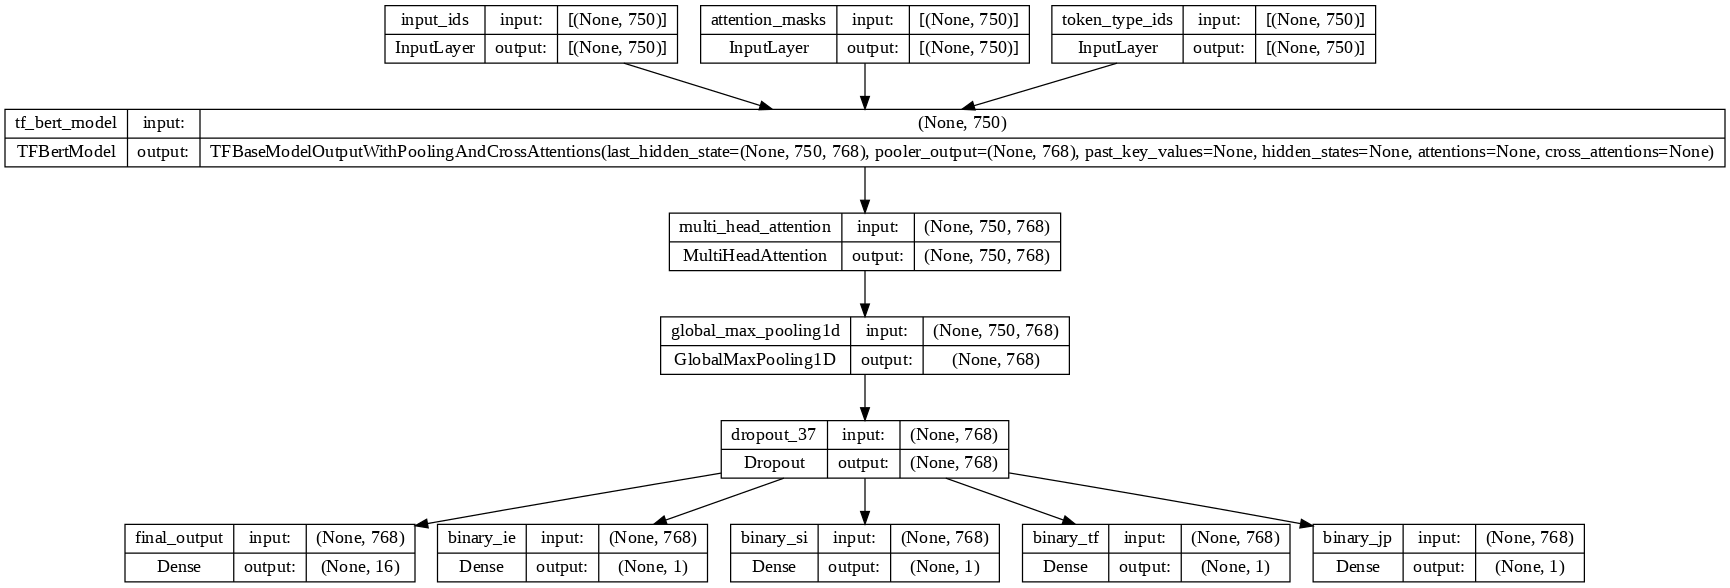

In [51]:
keras.utils.plot_model(mbti_bert_mh_bin_model, show_shapes=True, dpi=90)

In [44]:
mbti_bert_mh_bin_model_history = mbti_bert_mh_bin_model.fit(train_data_generator,    
                                                  validation_data=dev_data_generator,    
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=4)

Epoch 1/4
1875/1875 [==============================] - 1363s 719ms/step - loss: 1.9568 - final_output_loss: 0.8054 - binary_ie_loss: 0.2910 - binary_si_loss: 0.2706 - binary_tf_loss: 0.2982 - binary_jp_loss: 0.2915 - final_output_accuracy: 0.7745 - binary_ie_accuracy: 0.8650 - binary_si_accuracy: 0.8757 - binary_tf_accuracy: 0.8613 - binary_jp_accuracy: 0.8622 - val_loss: 1.1964 - val_final_output_loss: 0.5159 - val_binary_ie_loss: 0.1783 - val_binary_si_loss: 0.1310 - val_binary_tf_loss: 0.1927 - val_binary_jp_loss: 0.1785 - val_final_output_accuracy: 0.8604 - val_binary_ie_accuracy: 0.9233 - val_binary_si_accuracy: 0.9485 - val_binary_tf_accuracy: 0.9144 - val_binary_jp_accuracy: 0.9192
Epoch 2/4
1875/1875 [==============================] - 1273s 679ms/step - loss: 1.0220 - final_output_loss: 0.4251 - binary_ie_loss: 0.1493 - binary_si_loss: 0.1361 - binary_tf_loss: 0.1580 - binary_jp_loss: 0.1536 - final_output_accuracy: 0.8873 - binary_ie_accuracy: 0.9411 - binary_si_accuracy: 0.94

In [52]:
from sklearn.metrics import confusion_matrix
def document_multimodel_run(model_type,mbti_model,target_names,ie,si,thinkfeel,jp,results_dict,input_ids,token_type_ids,attention_mask,nptest_labels,labels_ie,labels_si,labels_tf,labels_jp):

  # score = mbti_model.evaluate([input_ids,token_type_ids,attention_mask],nptest_labels) 
  # print('Test loss:', score[0]) 
  # print('Test accuracy:', score[1])
  # Get Entire Predictions
  predictions = mbti_model.predict([input_ids,token_type_ids,attention_mask])

  
  multiclass_predictions = np.argmax(predictions[0],axis=-1)


  b_ie = np.array(predictions[1] > 0.5,dtype=bool)
  b_si = np.array(predictions[2] > 0.5,dtype=bool)
  b_tf = np.array(predictions[3] > 0.5,dtype=bool)
  b_jp = np.array(predictions[4] > 0.5,dtype=bool)

  #Multiclass classification
  print(classification_report(nptest_labels, multiclass_predictions,target_names=target_names))

  cr_multi = classification_report(nptest_labels, multiclass_predictions, target_names=target_names)

  cm_multi = confusion_matrix(nptest_labels, multiclass_predictions)
  cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_multi, annot=True,
      xticklabels=target_names,
      yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  # #Binary classification Introvert vs Extrovert
  print(classification_report(labels_ie,b_ie,target_names=ie))

  cr_ie = classification_report(labels_ie, b_ie,target_names=ie)

  cm_ie = confusion_matrix(labels_ie, b_ie)
  cm_ie = cm_ie/cm_ie.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_ie, annot=True,
      xticklabels=ie,
      yticklabels=ie)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  
  # #Binary classification Sensing vs intution
  print(classification_report(labels_si,b_si,target_names=si))

  cr_si = classification_report(labels_si, b_si,target_names=si)

  cm_si = confusion_matrix(labels_si, b_si)
  cm_si = cm_si/cm_si.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_si, annot=True,
      xticklabels=si,
      yticklabels=si)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  
  # #Binary classification Thinking vs Feeling
  print(classification_report(labels_tf,b_tf,target_names=tf))

  cr_tf = classification_report(labels_tf, b_tf,target_names=tf)

  cm_tf = confusion_matrix(labels_tf, b_tf)
  cm_tf = cm_tf/cm_tf.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_tf, annot=True,
      xticklabels=tf,
      yticklabels=tf)
  plt.xlabel("Predicted")
  plt.ylabel("True")



  # #Binary classification Judging vs Perceiving
  print(classification_report(labels_jp,b_jp,target_names=jp))

  cr_jp = classification_report(labels_jp, b_jp,target_names=jp)

  cm_jp = confusion_matrix(labels_jp, b_jp)
  cm_jp = cm_jp/cm_jp.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm_jp, annot=True,
      xticklabels=jp,
      yticklabels=jp)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  # results_dict[model_type] = {'model_type': model_type,
  #                             'cm':cm,
  #                             'cr':cr,
  #                             'test_loss': score[0],
  #                             'test_accuracy': score[1]
  #                             }

Question 3 : Do we need to report on all 5 different loss and accuracy scores for test

63/63 [==============================] - 16s 256ms/step
              precision    recall  f1-score   support

        ISTJ       0.79      0.70      0.74        33
        INTJ       0.83      0.84      0.83       257
        ESTJ       0.72      1.00      0.84        51
        ENTJ       0.91      0.85      0.88        81
        ENTP       0.81      0.66      0.73       196
        INTP       0.97      0.51      0.67       278
        ISTP       0.54      0.87      0.66        85
        ESTP       0.48      1.00      0.65        41
        ISFJ       0.92      0.71      0.80        31
        INFJ       0.65      0.70      0.67       191
        ESFJ       0.73      0.98      0.84        45
        ENFJ       0.95      0.76      0.85        68
        ENFP       0.64      0.90      0.75       250
        INFP       0.85      0.65      0.74       271
        ISFP       0.91      0.98      0.94        84
        ESFP       0.97      0.97      0.97        38

    accuracy            

TypeError: ignored

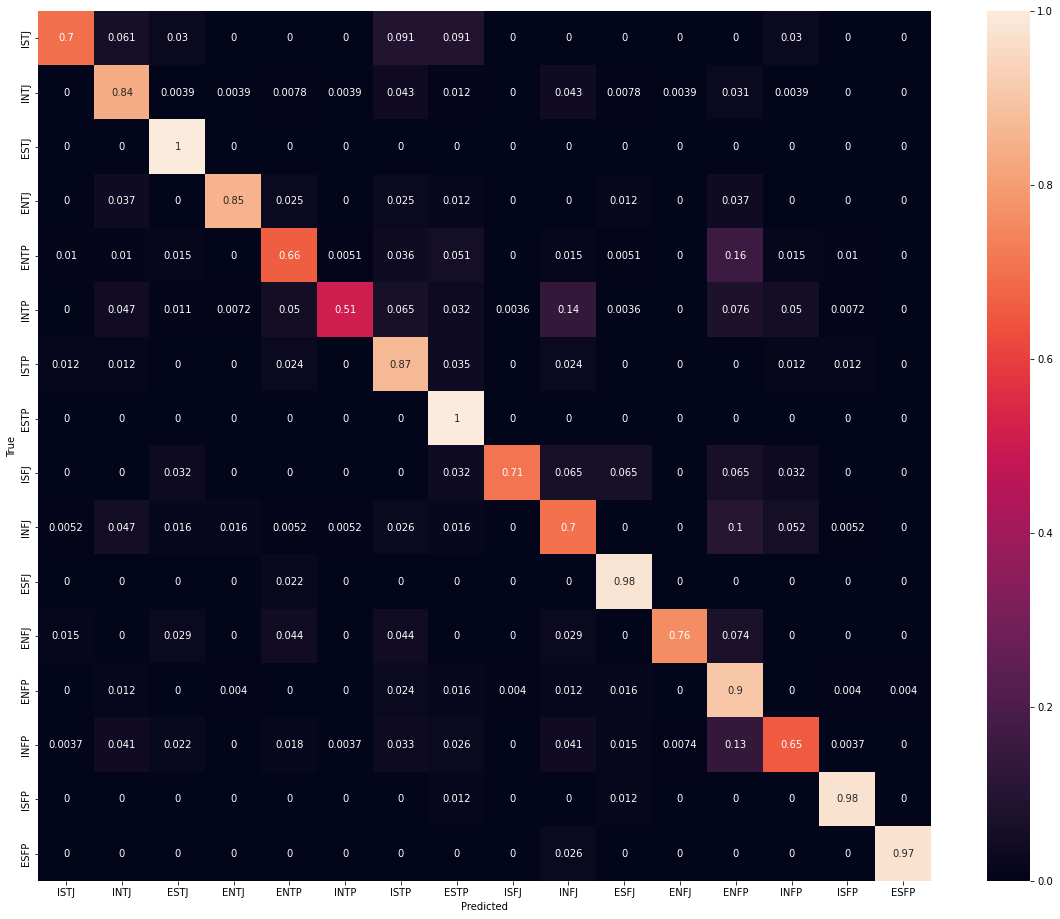

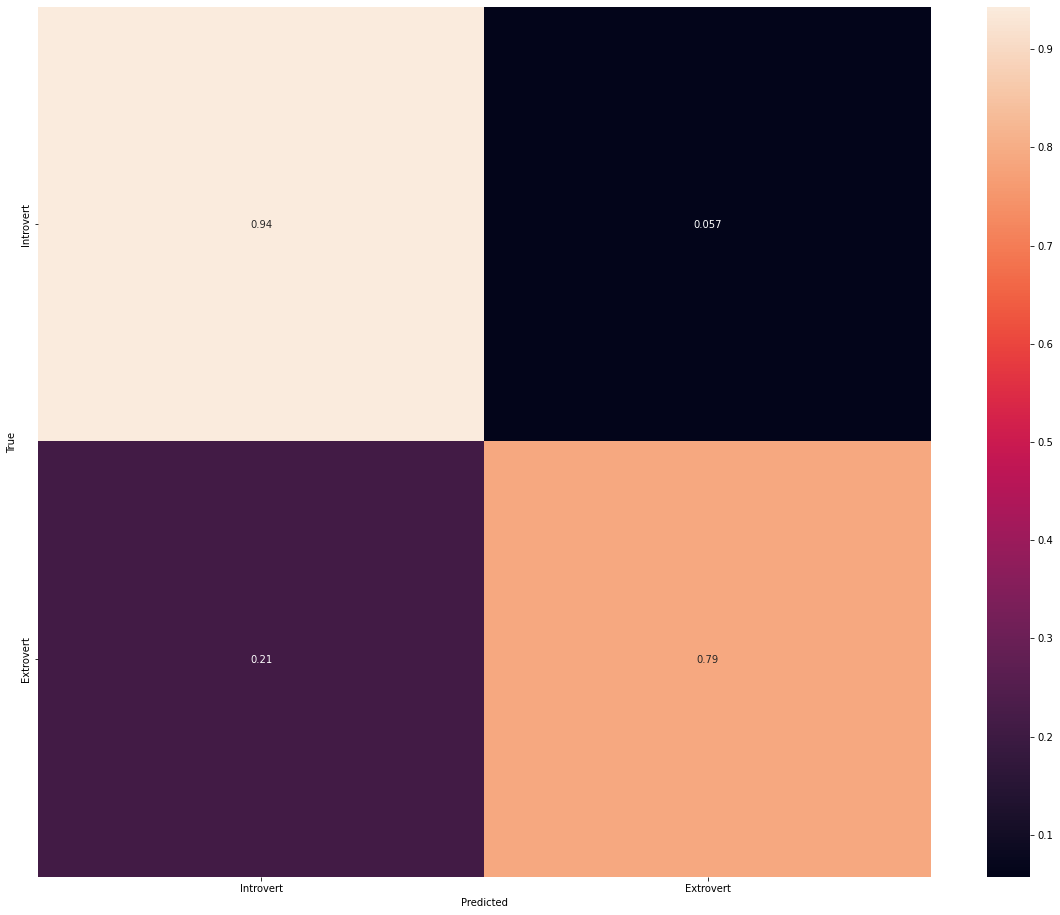

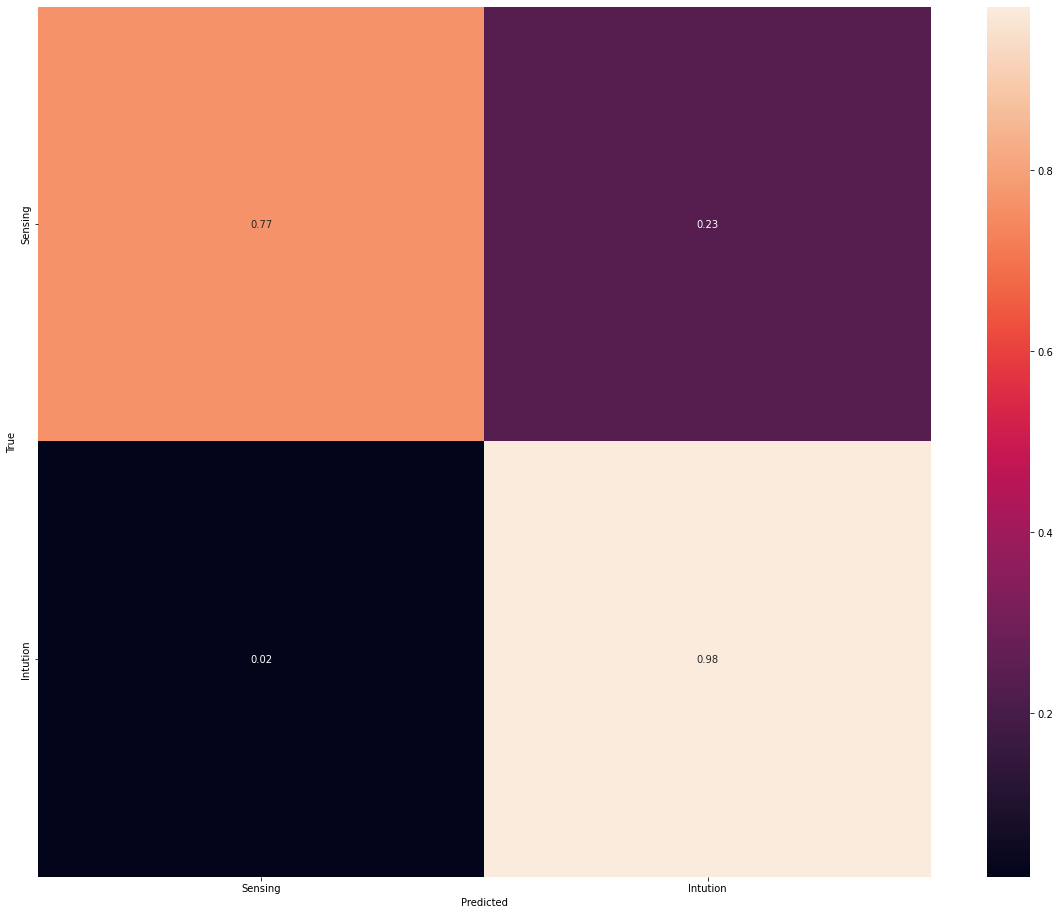

In [53]:
document_multimodel_run('mbti_bert_mh_bin_model',
                   mbti_bert_mh_bin_model,
                   valid_MBTI,ie,si,thinkfeel,jp,results_dict,
                   test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
                   nptest_labels,labels_ie,labels_si,labels_tf,labels_jp)

# Multihead attention model no CNN

In [ ]:
# # this one is based on the multiheaded attention added 
# def create_mbti_bert_mh_model(bert_model,
#                                 hidden_size = 501, 
#                                 dropout=0.3,
#                                 learning_rate=0.00005,max_length=750):
#     """
#     Build a simple classification model with BERT. Add self attention layers on top of BERT output , training entire BERT is costly
#     """

#     input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
#     attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
#     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')
  
#     bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
#     sequence_output = bert_output.last_hidden_state

#     #attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
#     #Fix 1 increasing key dim to match the max length  
#     attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=250)(sequence_output, sequence_output)
#     max_pool = layers.GlobalMaxPooling1D()(attn_output)
#     dropout_output = layers.Dropout(0.3)(max_pool)
#     final_output = layers.Dense(16, activation="softmax")(dropout_output)
    
#     model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
#                                   outputs=[final_output])
#     model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [ ]:
# mbti_bert_mh_model = create_mbti_bert_mh_model(bert_model)

In [ ]:
# mbti_bert_mh_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 750)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 750)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 750)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

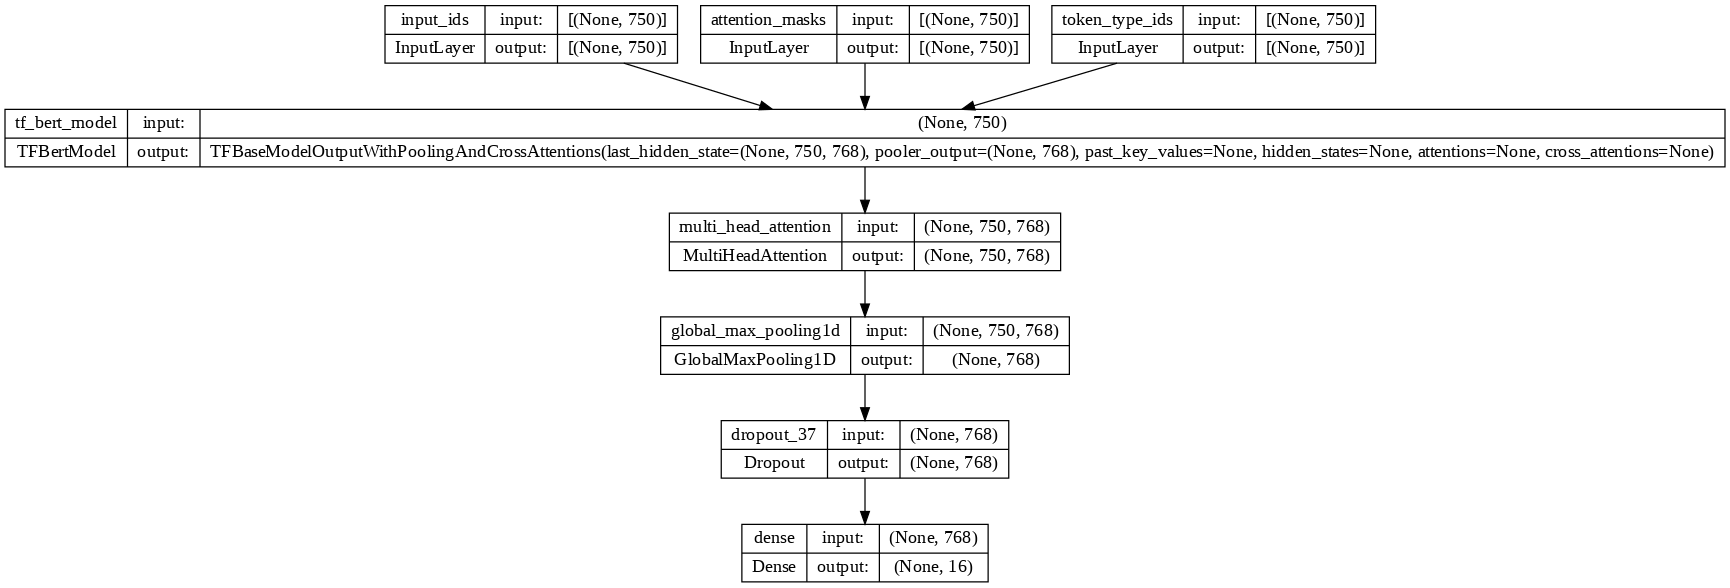

In [ ]:
# keras.utils.plot_model(mbti_bert_mh_model, show_shapes=True, dpi=90)

In [ ]:
# mbti_bert_mh_model_history = mbti_bert_mh_model.fit(train_data_generator,    
#                                                   validation_data=dev_data_generator,    
#                                                   callbacks=[model_checkpoint_callback],
#                                                   epochs=4)

Epoch 1/4
62/62 [==============================] - 194s 3s/step - loss: 2.9043 - accuracy: 0.0736 - val_loss: 2.9800 - val_accuracy: 0.0536
Epoch 2/4
62/62 [==============================] - 186s 3s/step - loss: 2.4542 - accuracy: 0.2334 - val_loss: 2.5128 - val_accuracy: 0.2098
Epoch 3/4
62/62 [==============================] - 186s 3s/step - loss: 1.5634 - accuracy: 0.5328 - val_loss: 2.1309 - val_accuracy: 0.4330
Epoch 4/4
62/62 [==============================] - 186s 3s/step - loss: 1.0897 - accuracy: 0.6845 - val_loss: 1.4098 - val_accuracy: 0.6116


In [ ]:
# mbti_bert_mh_model_history = mbti_bert_mh_model.fit(train_data_generator,    
#                                                   validation_data=([dev_encodings.input_ids,dev_encodings.token_type_ids, dev_encodings.attention_mask],npdev_labels),    
#                                                   callbacks=[model_checkpoint_callback],
#                                                   epochs=1)

32/32 [==============================] - 67s 2s/step - loss: 2.6385 - accuracy: 0.4220
Test loss: 2.6385433673858643
Test accuracy: 0.421999990940094
32/32 [==============================] - 69s 2s/step
              precision    recall  f1-score   support

        ISTJ       0.92      0.46      0.61        24
        INTJ       0.39      0.63      0.48       128
        ESTJ       0.76      0.93      0.83        27
        ENTJ       0.91      0.26      0.40        39
        ENTP       0.31      0.26      0.28        93
        INTP       0.76      0.21      0.33       133
        ISTP       0.12      0.76      0.21        50
        ESTP       0.53      1.00      0.70        24
        ISFJ       0.62      0.42      0.50        12
        INFJ       0.94      0.15      0.26       104
        ESFJ       0.67      0.76      0.71        21
        ENFJ       0.85      0.68      0.75        34
        ENFP       0.66      0.40      0.50       127
        INFP       0.45      0.22      0

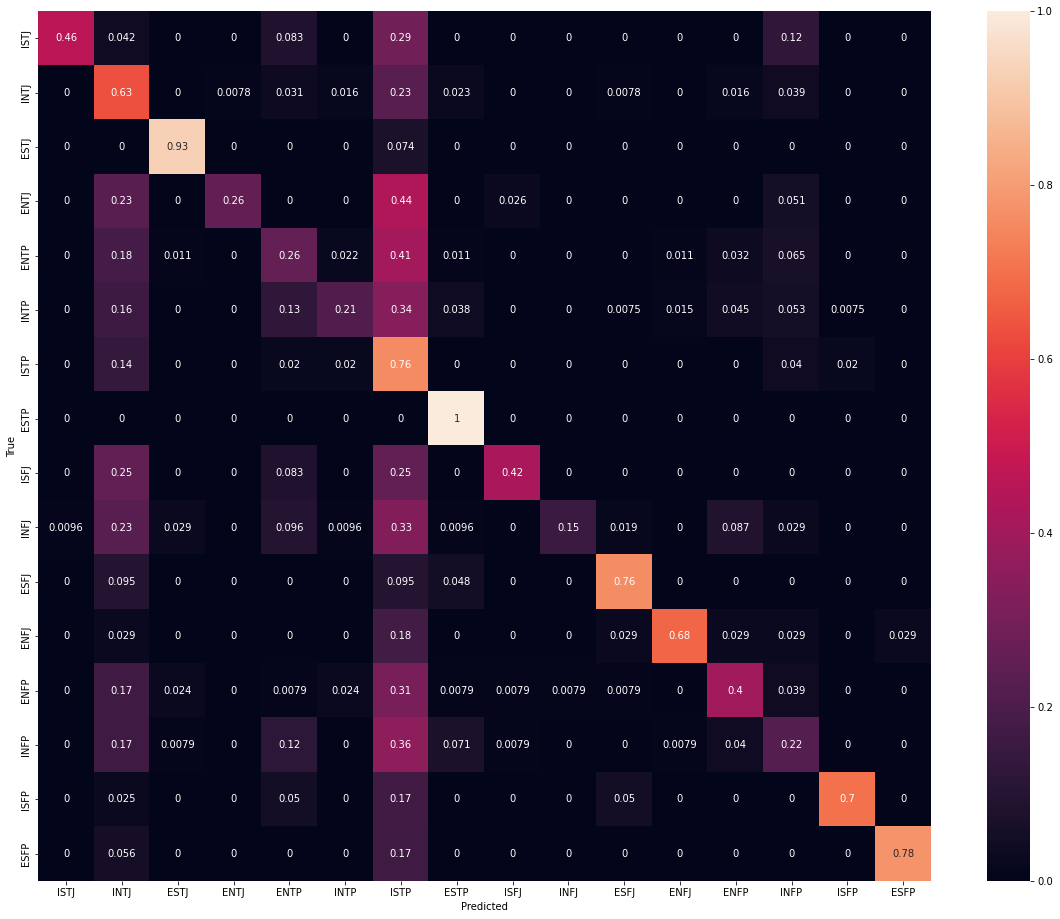

In [ ]:
# document_model_run('mbti_bert_mh_model',
#                    mbti_bert_mh_model,
#                    valid_MBTI,results_dict,
#                    test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
#                    nptest_labels)

In [ ]:

# results_filepath = checkpoint_dir + 'bert_mh_results_1113.txt'
# f = open(results_filepath,"w")

# # write file
# f.write( str(results_dict) )

# # close file
# f.close()

# Lots of testing code do not delete focus on this for tuning

In [ ]:
  predictions = mbti_bert_mh_model.predict([test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask])

  predictions = tf.argmax(predictions, axis=-1)

  predictions = predictions.numpy()

250/250 [==============================] - 538s 2s/step


In [ ]:
test_combined[test_combined['truth']==test_combined['prediction']].count()

original index         2496
Username               2496
Age                    2496
Posts                  2496
Enneagram              2071
Instinctual Variant    1638
Gender                 1509
Occupation             1480
is_I                   2496
is_S                   2496
is_T                   2496
is_J                   2496
post_id                2496
thread_id              2496
post_date              2496
message                2496
lexicon                2496
emotions               2496
postags                2496
combined               2496
original index         2496
MBTI Type              2496
prediction             2496
truth                  2496
dtype: int64

In [ ]:
test_combined['messagelength'] = test_combined['message'].str.split().apply(len)

In [ ]:
testlen = test_combined.iloc[0]['message']

In [ ]:
len(testlen.split())

67

In [ ]:
test_combined['message'].str.split().apply(len).value_counts()

1       353
7       194
6       187
3       176
5       174
       ... 
447       1
715       1
4098      1
701       1
916       1
Name: message, Length: 538, dtype: int64

In [ ]:
test_combined

,original index,Username,Age,Posts,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,...,lexicon,emotions,postags,combined,original index,MBTI Type,prediction,truth,messagelength,accurate
1400000,110045,athenian200,34.0,8828,4w5,None,None,None,True,False,...,"social_media 2.0, computer 1.0, internet 3.0, ...","positive 1, fear 1, negative 1","intj 1, punct 10, propn 2, pron 11, adv 7, ver...",athenian200 [SEP] 34.0 [SEP] 8828 [SEP] None [...,110045,INFJ,6,9,67,False
1400001,107821,athenian200,34.0,8828,4w5,None,None,None,True,False,...,"school 1.0, speaking 1.0",negative 1,"space 1, pron 4, aux 3, verb 2, adv 4, punct 3...",athenian200 [SEP] 34.0 [SEP] 8828 [SEP] None [...,107821,INFJ,14,9,19,False
1400002,865471,littleclaypot,34.0,629,297,so_sx,female,history teacher.,True,False,...,"hate 1.0, tourism 1.0, beach 1.0, ridicule 1.0...","joy 3, positive 3, trust 3, anticipation 1, su...","space 2, adp 8, det 4, adj 11, punct 6, pron 6...",littleclaypot [SEP] 34.0 [SEP] 629 [SEP] femal...,865471,INFJ,10,9,61,False
1400003,354073,eck,36.0,7705,738,None,male,yes,False,False,...,"sleep 1.0, furniture 1.0, eating 1.0, negative...","anger 1, fear 1, negative 1, sadness 1","pron 3, aux 4, punct 3, det 5, noun 6, adp 5, ...",eck [SEP] 36.0 [SEP] 7705 [SEP] male [SEP] yes...,354073,ENTP,13,4,31,False
1400004,1412046,thalassa,45.0,25183,6w7,sx,not_specified,tree people,True,True,...,,,"aux 1, verb 1, noun 2, punct 1, space 1",thalassa [SEP] 45.0 [SEP] 25183 [SEP] not_spec...,1412046,ISFP,14,14,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407995,397731,ejcc,31.0,19129,1w9,sp_so,female,None,False,True,...,"anticipation 1.0, noise 1.0, air_travel 1.0, f...","fear 1, negative 1, sadness 1, surprise 1, pos...","space 2, pron 6, verb 6, sconj 3, adj 6, noun ...",ejcc [SEP] 31.0 [SEP] 19129 [SEP] female [SEP]...,397731,ESTJ,13,2,55,False
1407996,1346942,sprinkles,46.0,2959,None,None,not_specified,None,True,False,...,"morning 1.0, ridicule 1.0, play 1.0, childish ...","negative 4, positive 2, joy 2, trust 2, anger ...","space 6, pron 6, aux 2, adj 6, adp 3, noun 13,...",sprinkles [SEP] 46.0 [SEP] 2959 [SEP] not_spec...,1346942,INFJ,10,9,48,False
1407997,1201782,salomã©,22.0,10527,5w4,sx_sp,None,None,True,False,...,"money 1.0, leisure 1.0, wealthy 2.0, banking 1...","positive 3, trust 2, anticipation 2, joy 1, su...","adj 8, noun 9, aux 5, adp 3, punct 7, cconj 1,...",salomã© [SEP] 22.0 [SEP] 10527 [SEP] None [SEP...,1201782,INTP,6,5,41,False
1407998,970206,nolla,40.0,3166,None,None,None,unemployed creative person,True,False,...,,trust 1,"propn 1, aux 2, verb 2, part 1, det 1, adj 3, ...",nolla [SEP] 40.0 [SEP] 3166 [SEP] None [SEP] u...,970206,INFP,13,13,14,True


In [ ]:
test_combined['accurate'] = test_combined['truth']== test_combined['prediction']

In [ ]:
gender_df= test_combined[['Gender','truth','accurate']]

In [ ]:
test_combined.Occupation.value_counts()

student                        199
tree people                    148
consulting                     132
lyrical souljah                113
photographer                   100
                              ... 
tile setter/musician/artist      1
tutor                            1
business systems analyst         1
none. maybe in the summer.       1
student/ freelance designer      1
Name: Occupation, Length: 403, dtype: int64

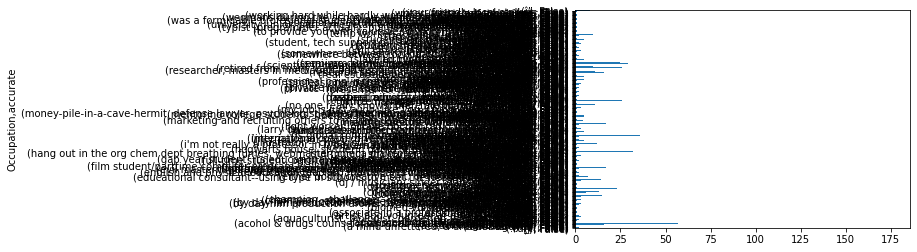

In [ ]:
test_combined.groupby('Occupation')['accurate'].value_counts().plot(kind='barh')

In [ ]:
test_combined

,original index,Username,Age,Posts,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,...,lexicon,emotions,postags,combined,original index,MBTI Type,prediction,truth,messagelength,accurate
1400000,110045,athenian200,34.0,8828,4w5,None,None,None,True,False,...,"social_media 2.0, computer 1.0, internet 3.0, ...","positive 1, fear 1, negative 1","intj 1, punct 10, propn 2, pron 11, adv 7, ver...",athenian200 [SEP] 34.0 [SEP] 8828 [SEP] None [...,110045,INFJ,6,9,67,False
1400001,107821,athenian200,34.0,8828,4w5,None,None,None,True,False,...,"school 1.0, speaking 1.0",negative 1,"space 1, pron 4, aux 3, verb 2, adv 4, punct 3...",athenian200 [SEP] 34.0 [SEP] 8828 [SEP] None [...,107821,INFJ,14,9,19,False
1400002,865471,littleclaypot,34.0,629,297,so_sx,female,history teacher.,True,False,...,"hate 1.0, tourism 1.0, beach 1.0, ridicule 1.0...","joy 3, positive 3, trust 3, anticipation 1, su...","space 2, adp 8, det 4, adj 11, punct 6, pron 6...",littleclaypot [SEP] 34.0 [SEP] 629 [SEP] femal...,865471,INFJ,10,9,61,False
1400003,354073,eck,36.0,7705,738,None,male,yes,False,False,...,"sleep 1.0, furniture 1.0, eating 1.0, negative...","anger 1, fear 1, negative 1, sadness 1","pron 3, aux 4, punct 3, det 5, noun 6, adp 5, ...",eck [SEP] 36.0 [SEP] 7705 [SEP] male [SEP] yes...,354073,ENTP,13,4,31,False
1400004,1412046,thalassa,45.0,25183,6w7,sx,not_specified,tree people,True,True,...,,,"aux 1, verb 1, noun 2, punct 1, space 1",thalassa [SEP] 45.0 [SEP] 25183 [SEP] not_spec...,1412046,ISFP,14,14,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407995,397731,ejcc,31.0,19129,1w9,sp_so,female,None,False,True,...,"anticipation 1.0, noise 1.0, air_travel 1.0, f...","fear 1, negative 1, sadness 1, surprise 1, pos...","space 2, pron 6, verb 6, sconj 3, adj 6, noun ...",ejcc [SEP] 31.0 [SEP] 19129 [SEP] female [SEP]...,397731,ESTJ,13,2,55,False
1407996,1346942,sprinkles,46.0,2959,None,None,not_specified,None,True,False,...,"morning 1.0, ridicule 1.0, play 1.0, childish ...","negative 4, positive 2, joy 2, trust 2, anger ...","space 6, pron 6, aux 2, adj 6, adp 3, noun 13,...",sprinkles [SEP] 46.0 [SEP] 2959 [SEP] not_spec...,1346942,INFJ,10,9,48,False
1407997,1201782,salomã©,22.0,10527,5w4,sx_sp,None,None,True,False,...,"money 1.0, leisure 1.0, wealthy 2.0, banking 1...","positive 3, trust 2, anticipation 2, joy 1, su...","adj 8, noun 9, aux 5, adp 3, punct 7, cconj 1,...",salomã© [SEP] 22.0 [SEP] 10527 [SEP] None [SEP...,1201782,INTP,6,5,41,False
1407998,970206,nolla,40.0,3166,None,None,None,unemployed creative person,True,False,...,,trust 1,"propn 1, aux 2, verb 2, part 1, det 1, adj 3, ...",nolla [SEP] 40.0 [SEP] 3166 [SEP] None [SEP] u...,970206,INFP,13,13,14,True


In [ ]:
empty_emotions = test_combined[test_combined['emotions'] == ""]

In [ ]:
empty_emotions_true = test_combined[test_combined['emotions'] == "" & test_combined['truth'] == test_combined['prediction']]

TypeError: ignored

In [ ]:
test_combined[test_combined['postags'] == ""]['message']

Series([], Name: message, dtype: object)

In [ ]:
empty_emotions.iloc[1]

original index                                                    619878
Username                                             julius_van_der_beak
Age                                                                 62.0
Posts                                                              26248
Enneagram                                                            6w5
Instinctual Variant                                                sx_sp
Gender                                                              male
Occupation                                                    consulting
is_I                                                                True
is_S                                                               False
is_T                                                                True
is_J                                                                True
post_id                                                          2850449
thread_id                                          

In [ ]:
test_combined.count()

original index         8000
Username               8000
Age                    8000
Posts                  8000
Enneagram              6043
Instinctual Variant    4078
Gender                 4113
Occupation             4159
is_I                   8000
is_S                   8000
is_T                   8000
is_J                   8000
post_id                8000
thread_id              8000
post_date              8000
message                8000
lexicon                8000
emotions               8000
postags                8000
combined               8000
original index         8000
MBTI Type              8000
prediction             8000
truth                  8000
messagelength          8000
accurate               8000
dtype: int64

In [ ]:
test_combined.groupby(['postags', 'accurate'])['accurate'].count().unstack()

accurate,False,True
postags,,
adj 1,6.0,3.0
"adj 1, adp 1, det 1, noun 1, punct 1",1.0,NaN
"adj 1, adp 1, det 1, noun 1, punct 2, space 1",1.0,NaN
"adj 1, adp 1, det 1, noun 2, punct 1, verb 1, pron 1",1.0,NaN
"adj 1, adp 1, det 1, noun 2, punct 2, pron 3, verb 2",1.0,NaN
...,...,...
"x 7, punct 14, space 4, pron 13, aux 8, adv 3, adj 10, adp 9, det 7, noun 18, verb 12, propn 3, sconj 4, part 7, cconj 2",1.0,NaN
"x 7, space 1, punct 2",1.0,NaN
"x 7, space 3, intj 1, punct 5, pron 3, aux 2, det 3, num 1, verb 2, noun 2",NaN,1.0


In [ ]:
test_combined.groupby(['lexicon', 'accurate'])['accurate'].count().unstack()

accurate,False,True
lexicon,,
,1200.0,371.0
achievement 1.0,3.0,NaN
"achievement 1.0, positive_emotion 1.0",5.0,1.0
affection 1.0,NaN,1.0
"affection 1.0, animal 3.0",1.0,NaN
...,...,...
"wedding 7.0, domestic_work 5.0, cold 1.0, aggression 1.0, anticipation 1.0, family 7.0, dispute 1.0, nervousness 2.0, leisure 5.0, art 1.0, home 7.0, sexual 1.0, business 1.0, cooking 1.0, surprise 1.0, leader 1.0, body 1.0, eating 1.0, confusion 1.0, death 1.0, celebration 8.0, restaurant 1.0, violence 1.0, love 1.0, communication 1.0, trust 2.0, deception 1.0, gain 1.0, work 1.0, shame 1.0, party 8.0, poor 1.0, pain 1.0, timidity 1.0, negative_emotion 2.0, law 1.0, friends 2.0, alcohol 1.0, children 7.0, contentment 1.0, positive_emotion 6.0",NaN,1.0
"youth 1.0, children 1.0, rural 1.0",NaN,1.0
"zest 1.0, confusion 1.0",1.0,NaN


In [ ]:
test_combined.groupby(['emotions', 'accurate'])['accurate'].count().unstack()

accurate,False,True
emotions,,
,1266.0,403.0
anger 1,9.0,3.0
"anger 1, anticipation 1",1.0,NaN
"anger 1, anticipation 1, disgust 1, fear 1, joy 1, negative 1, positive 1, sadness 1, surprise 1, trust 1",5.0,1.0
"anger 1, anticipation 1, disgust 1, fear 1, joy 1, positive 1, trust 1",1.0,NaN
...,...,...
"trust 9, fear 3, negative 3, sadness 2, positive 8, joy 3, anger 2, disgust 1, surprise 2",1.0,NaN
"trust 9, negative 5, anticipation 4, fear 1, joy 3, positive 5, anger 2, disgust 2, sadness 3",NaN,1.0
"trust 9, positive 12, anger 2, anticipation 7, joy 7, surprise 4, negative 3, sadness 2, disgust 1, fear 1",NaN,1.0


In [ ]:
#this is correct implementation
test_combined.groupby(['Age', 'accurate'])['accurate'].count().unstack()

accurate,False,True
Age,,
6.0,21.0,NaN
10.0,25.0,1.0
16.0,NaN,2.0
17.0,2.0,NaN
18.0,4.0,NaN
...,...,...
112.0,27.0,2.0
119.0,3.0,NaN
120.0,29.0,1.0


In [ ]:
#this is screwed up dont run this
# test_combined['Username'] ='julius_van_der_beak'

In [ ]:
test_combined.groupby(['Username', 'accurate'])['accurate'].count().unstack()

accurate,False,True
Username,,
julius_van_der_beak,5504,2496


In [ ]:
test_combined.groupby(['Username', 'accurate','MBTI Type'])['accurate'].count().unstack()

MBTI Type                         ENFJ  ENFP  ENTJ  ENTP  ESFJ  ESFP  ESTJ  \
Username                accurate                                             
1010830                 False      NaN   NaN   1.0   NaN   NaN   NaN   NaN   
10blackroses            False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
21%                     False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                        True       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5231311252              False      NaN   NaN   NaN   NaN   1.0   NaN   NaN   
...                                ...   ...   ...   ...   ...   ...   ...   
znp-tba                 False      NaN   NaN   NaN  15.0   NaN   NaN   NaN   
zpowers                 False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
ztx                     False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
❀༺♥༻ℭ𝔞𝔢𝔩𝔦𝔞_𝔄𝔦𝔰𝔩𝔦𝔫𝔤༺♥༻❀༺ False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                        True       NaN   NaN   NaN   NaN   NaN   NaN   NaN   

MBTI Type                         ESTP  INFJ  INFP  INTJ  INTP  ISFJ  ISFP  \
Username                accurate                                             
1010830                 False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10blackroses            False      NaN   NaN   NaN   1.0   NaN   NaN   NaN   
21%                     False      NaN  15.0   NaN   NaN   NaN   NaN   NaN   
                        True       NaN   1.0   NaN   NaN   NaN   NaN   NaN   
5231311252              False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                                ...   ...   ...   ...   ...   ...   ...   
znp-tba                 False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
zpowers                 False      NaN   NaN   NaN   NaN   7.0   NaN   NaN   
ztx                     False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   
❀༺♥༻ℭ𝔞𝔢𝔩𝔦𝔞_𝔄𝔦𝔰𝔩𝔦𝔫𝔤༺♥༻❀༺ False      NaN   NaN   1.0   NaN   NaN   NaN   NaN   
                        True       NaN   NaN  17.0   NaN   NaN   NaN   NaN   

MBTI Type                         ISTJ  ISTP  
Username                accurate              
1010830                 False      NaN   NaN  
10blackroses            False      NaN   NaN  
21%                     False      NaN   NaN  
                        True       NaN   NaN  
5231311252              False      NaN   NaN  
...                                ...   ...  
znp-tba                 False      NaN   NaN  
zpowers                 False      NaN   NaN  
ztx                     False      NaN   1.0  
❀༺♥༻ℭ𝔞𝔢𝔩𝔦𝔞_𝔄𝔦𝔰𝔩𝔦𝔫𝔤༺♥༻❀༺ False      NaN   NaN  
                        True       NaN   NaN  

[1370 rows x 16 columns]

In [ ]:
test_combined.groupby(['Age', 'accurate','MBTI Type'])['accurate'].count().unstack()

MBTI Type        ENFJ  ENFP  ENTJ  ENTP  ESFJ  ESFP  ESTJ  ESTP  INFJ  INFP  \
Age    accurate                                                               
6.0    False      NaN  21.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10.0   False      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
       True       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16.0   True       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
17.0   False      NaN   2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
120.0  True       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021.0 False      NaN   7.0   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   
       True       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022.0 False      NaN   5.0  24.0  49.0   6.0   NaN   NaN  16.0  54.0   8.0   
       True       NaN   NaN   5.0   4.0  16.0   NaN   NaN   3.0   NaN  34.0   

MBTI Type        INTJ  INTP  ISFJ  ISFP  ISTJ  ISTP  
Age    accurate                                      
6.0    False      NaN   NaN   NaN   NaN   NaN   NaN  
10.0   False      NaN  25.0   NaN   NaN   NaN   NaN  
       True       NaN   1.0   NaN   NaN   NaN   NaN  
16.0   True       NaN   NaN   NaN   2.0   NaN   NaN  
17.0   False      NaN   NaN   NaN   NaN   NaN   NaN  
...               ...   ...   ...   ...   ...   ...  
120.0  True       1.0   NaN   NaN   NaN   NaN   NaN  
2021.0 False      NaN   3.0   NaN   NaN   NaN   3.0  
       True       NaN   NaN   NaN   NaN   NaN   4.0  
2022.0 False     46.0  22.0   7.0   NaN  16.0  14.0  
       True      15.0   NaN  29.0   NaN   NaN  44.0  

[118 rows x 16 columns]

In [ ]:
test_combined.groupby(['Age', 'accurate','MBTI Type'])['truth'].sum().unstack()

MBTI Type        ENFJ   ENFP  ENTJ   ENTP   ESFJ  ESFP  ESTJ   ESTP   INFJ  \
Age    accurate                                                              
6.0    False      NaN  252.0   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
10.0   False      NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
       True       NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
16.0   True       NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
17.0   False      NaN   24.0   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
...               ...    ...   ...    ...    ...   ...   ...    ...    ...   
120.0  True       NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
2021.0 False      NaN   84.0   NaN    NaN    NaN   NaN   NaN    NaN    9.0   
       True       NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN   
2022.0 False      NaN   60.0  72.0  196.0   60.0   NaN   NaN  112.0  486.0   
       True       NaN    NaN  15.0   16.0  160.0   NaN   NaN   21.0    NaN   

MBTI Type         INFP  INTJ   INTP   ISFJ  ISFP  ISTJ   ISTP  
Age    accurate                                                
6.0    False       NaN   NaN    NaN    NaN   NaN   NaN    NaN  
10.0   False       NaN   NaN  125.0    NaN   NaN   NaN    NaN  
       True        NaN   NaN    5.0    NaN   NaN   NaN    NaN  
16.0   True        NaN   NaN    NaN    NaN  28.0   NaN    NaN  
17.0   False       NaN   NaN    NaN    NaN   NaN   NaN    NaN  
...                ...   ...    ...    ...   ...   ...    ...  
120.0  True        NaN   1.0    NaN    NaN   NaN   NaN    NaN  
2021.0 False       NaN   NaN   15.0    NaN   NaN   NaN   18.0  
       True        NaN   NaN    NaN    NaN   NaN   NaN   24.0  
2022.0 False     104.0  46.0  110.0   56.0   NaN   0.0   84.0  
       True      442.0  15.0    NaN  232.0   NaN   NaN  264.0  

[118 rows x 16 columns]

In [ ]:
test_combined.groupby(['Occupation', 'accurate'])['truth'].sum().unstack()

accurate,False,True
Occupation,,
:/,26.0,NaN
:run:,5.0,NaN
?,20.0,12.0
^_^,NaN,39.0
a boring one.,5.0,NaN
...,...,...
"writer, artist, self-employed",15.0,NaN
writer/artist/designer,NaN,26.0
yes,200.0,4.0


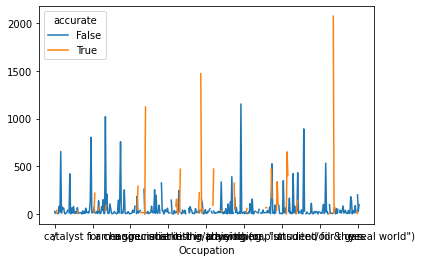

In [ ]:
test_combined.groupby(['Occupation', 'accurate'])['truth'].sum().unstack().plot()

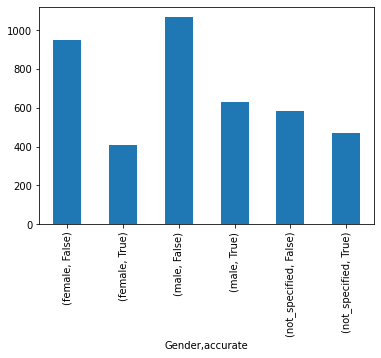

In [ ]:
#df.groupby('product')['sales'].plot(legend=True)
gender_df.groupby('Gender')['accurate'].value_counts().plot(kind='bar')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcde4fcb10>,
      dtype=object)

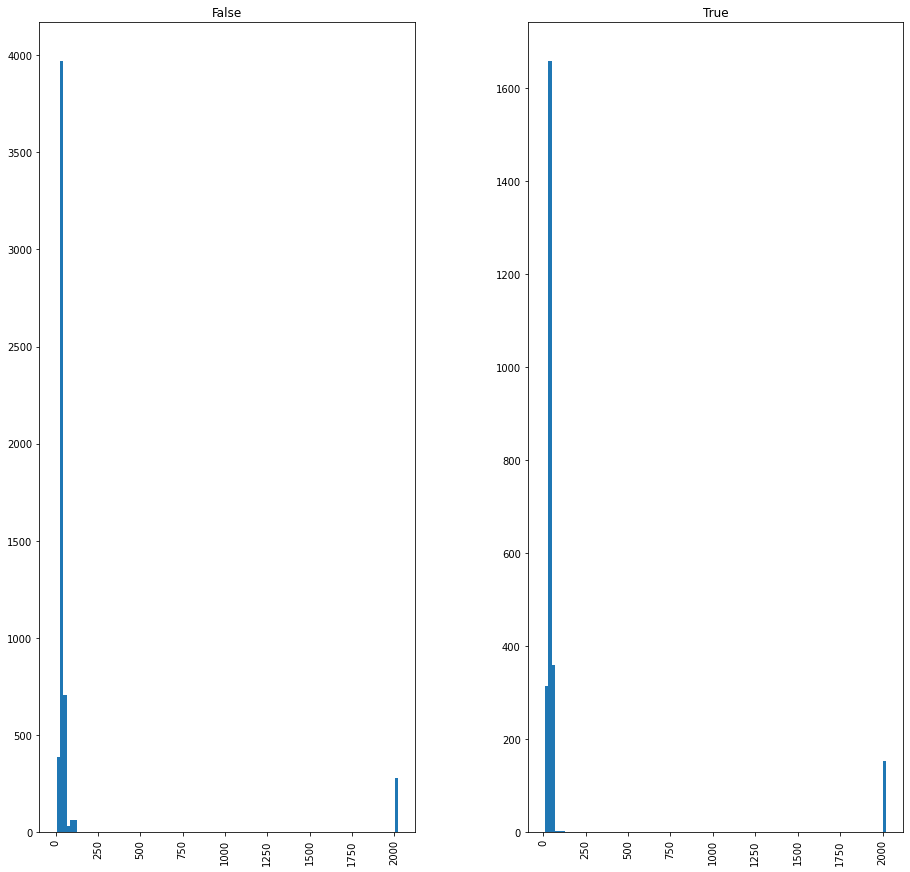

In [ ]:
test_combined.hist(column='Age',by='accurate',bins=100,figsize=(15, 15))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcdfc23190>,
      dtype=object)

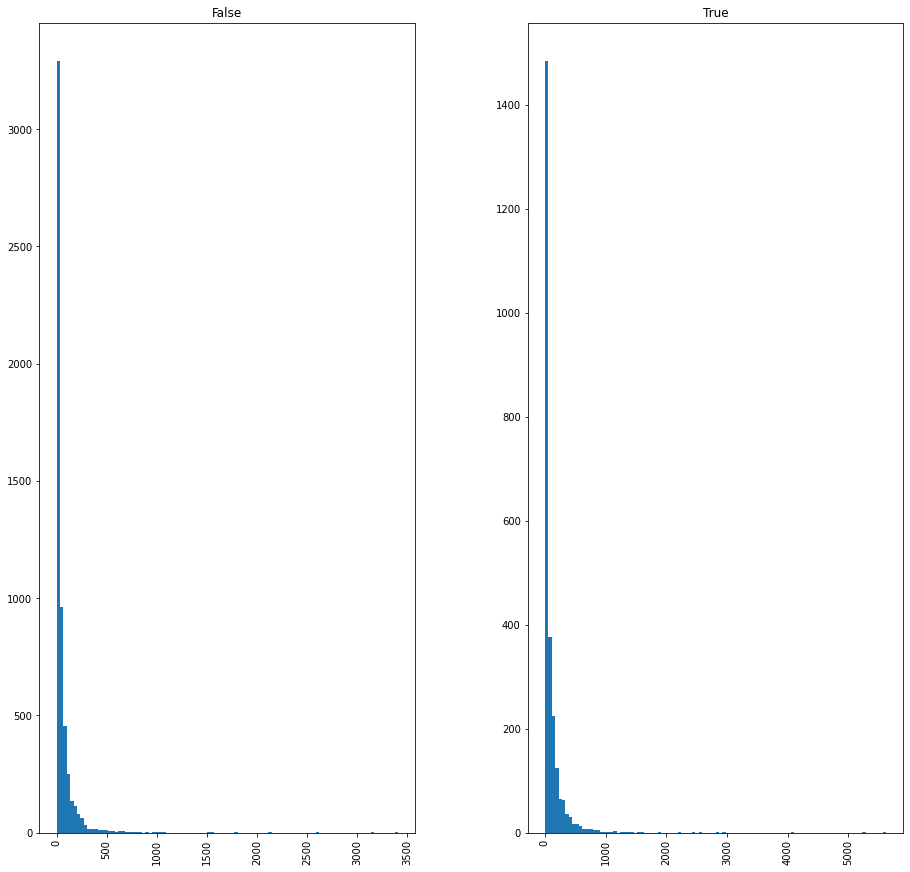

In [ ]:
test_combined.hist(column='messagelength',by='accurate',bins=100,figsize=(15, 15))

In [ ]:
test_combined['stopwords'] = test_combined['message'].str.split().apply(pct_stopwords).value_counts()

AttributeError: ignored

In [ ]:
test_combined['prediction'] = predictions.tolist()

In [ ]:
test_combined['truth'] = test_combined['MBTI Type'].map(valid_MBTI).values.tolist()

In [ ]:
correct ={}
wrong={}
correct['mbti_bert_mh_model'] = np.where(nptest_labels == predictions)
wrong['mbti_bert_mh_model'] = np.where(nptest_labels != predictions)

In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in correct['mbti_bert_mh_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in correct['mbti_bert_mh_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in correct['mbti_bert_mh_model'][0]]))

mean 160.86893203883494
min 14
max 3081


In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in wrong['mbti_bert_mh_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in wrong['mbti_bert_mh_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in wrong['mbti_bert_mh_model'][0]]))

mean 149.5969387755102
min 14
max 3559


In [ ]:
wrong_guesses = [i for i in np.squeeze(wrong['mbti_bert_mh_model'][0])]

In [ ]:
correct_guesses = [i for i in np.squeeze(correct['mbti_bert_mh_model'][0])]

In [ ]:
stops = {'a', 'the', 'an', 'one', 'these', 'those', 'this', 'that',
         'is', 'was', 'are', 'were'}

def pct_stopwords(text):
    toks = re.findall('\w+', text.lower())
    #b and a / b or 0
    return len(toks) and 100 * len([tok for tok in toks if tok in stops]) / len(toks) or 0

#pct_stopwords('This is a sentence with some stopwords in it.')


In [ ]:
for i in correct_guesses[:10]:
  #print("Combined Mess",test_mbti_data['combined'].values[i])
  #print("label type",test_mbti_labels['MBTI Type'].values[i])
  #print("Total Length",len(test_mbti_data['message'].values[i]))
  print("Stop Words",pct_stopwords(test_mbti_data['message'].values[i]))

Stop Words 0.0
Stop Words 0.0
Stop Words 11.11111111111111
Stop Words 14.285714285714286
Stop Words 23.076923076923077
Stop Words 0.0
Stop Words 14.349775784753364
Stop Words 0.0
Stop Words 21.21212121212121
Stop Words 7.5


In [ ]:
len(correct_guesses)

412

In [ ]:
tot = 0
for i in correct_guesses:
  tot = tot + pct_stopwords(test_mbti_data['message'].values[i])
print ("avg stop words in correct ", tot/412)

avg stop words in correct  11.329425449819025


In [ ]:
tot = 0
for i in wrong_guesses:
  tot = tot + pct_stopwords(test_mbti_data['message'].values[i])
print ("avg stop words in wrong ", tot/412)

avg stop words in wrong  15.267077541478878


In [ ]:
# for i in wrong_guesses:
#   #print("Combined Mess",test_mbti_data['combined'].values[i])
#   #print("label type",test_mbti_labels['MBTI Type'].values[i])
#   #print("Total Length",len(test_mbti_data['message'].values[i]))
#   print("Total Words",len(test_mbti_data['message'].values[i]))
#   print("Stop Words",pct_stopwords(test_mbti_data['message'].values[i]))

In [ ]:
stops = {'a', 'the', 'an', 'one', 'these', 'those', 'this', 'that',
         'is', 'was', 'are', 'were'}

def pct_stopwords(text):
    toks = re.findall('\w+', text.lower())
    return 100 * len([tok for tok in toks if tok in stops]) / len(toks)

pct_stopwords('This is a sentence with some stopwords in it.')


33.333333333333336

In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))

mean 94.2463768115942
min 0
max 794


In [ ]:
print('mean',np.mean([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))

mean 82.59720730397422
min 0
max 3163


In [ ]:
len(test_data_st[100].split())

260

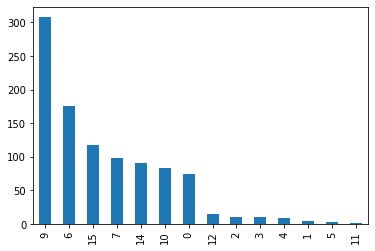

In [ ]:
pd.Series(predictions).value_counts().plot(kind = 'bar')

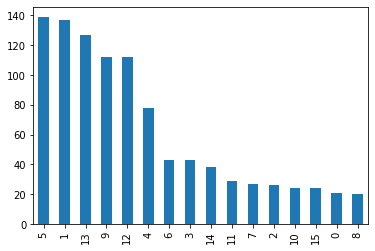

In [ ]:
pd.Series(nptest_labels).value_counts().plot(kind = 'bar')

# Notes and Next Steps


#update from 1120
Better results on pushing user profile data into BERT

Follow ups 
a) figure out how to find which results are coming wrong , focus on the testing section
b) plot those 
c) also run the same model, without actually passing the message and does the result degrade 
d) look at notes to self in Slack

